In [26]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.utils
from torch.utils.data import Dataset, DataLoader
import torch.distributions
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [27]:
plt.rcParams['figure.dpi'] = 200
print(torch.__version__)

2.0.0+cpu


In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [29]:
class Encoder(nn.Module):
    
    def __init__(self, inputdim, hiddendim, latentdim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(inputdim, hiddendim)
        self.linear2 = nn.Linear(hiddendim, latentdim)
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = func.relu(self.linear1(x))
        return self.linear2(x)

In [30]:
class Decoder(nn.Module):
    
    def __init__(self, inputdim, hiddendim, latentdim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latentdim, hiddendim)
        self.linear2 = nn.Linear(hiddendim, inputdim)
    
    def forward(self, z):
        z = func.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [31]:
class Autoencoder(nn.Module):
    
    def __init__(self, inputdim, hiddendim, latentdim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(inputdim, hiddendim, latentdim)
        self.decoder = Decoder(inputdim, hiddendim, latentdim)
     
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [32]:
inputdim = 784
hiddendim = 512
latentdim = 2

In [33]:
'''
Taken from the dataset page
'''

class DatasetMNIST(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        label = self.data.iloc[index, 0]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [34]:
traindataset = DatasetMNIST('../input/digit-recognizer/train.csv', transform=transforms.ToTensor())
testdataset = DatasetMNIST('../input/digit-recognizer/test.csv', transform=transforms.ToTensor())

In [35]:
image, label = traindataset.__getitem__(10)
print(image.shape, type(image))
print(image[0])

torch.Size([1, 28, 28]) <class 'torch.Tensor'>
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        

In [36]:
trainloaded = DataLoader(traindataset, batch_size=64, shuffle=True)
testloaded = DataLoader(testdataset, batch_size=64, shuffle=True)

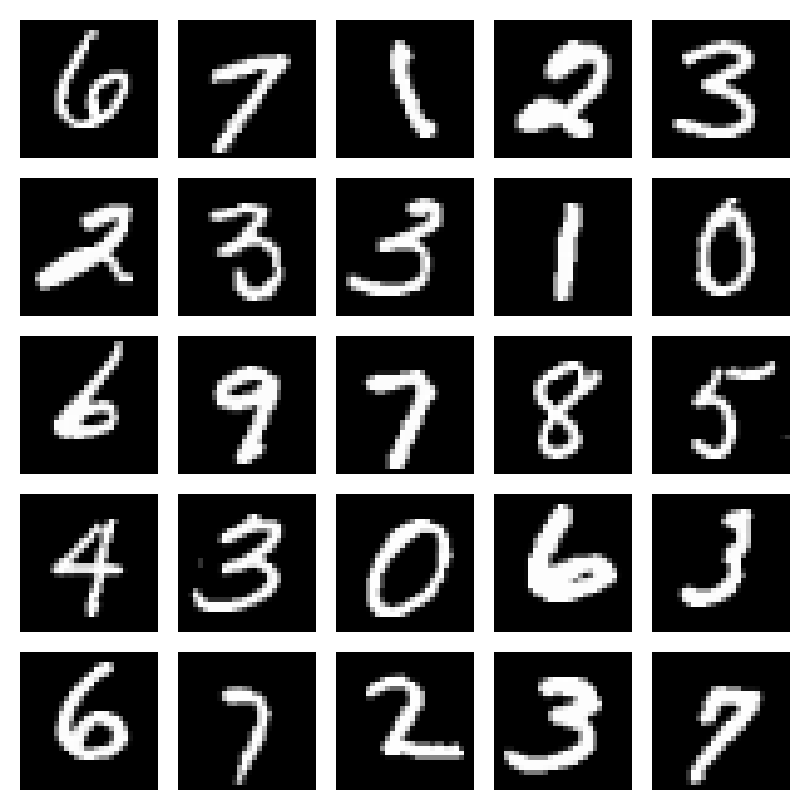

In [37]:
dataiter = iter(trainloaded)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 
fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)
for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [38]:
itercount = len(trainloaded)/64

In [39]:
def train(autoencoder, data, epochs=100):
    optim = torch.optim.Adam(autoencoder.parameters())
    for i in range(epochs):
        netloss = 0
        print("Epoch " + str(i + 1) +":", end = ' ')
        for x, y in data:
            x = x.to(device)
            optim.zero_grad()
            xhat = autoencoder(x)
            loss = ((x - xhat)**2).sum()
            netloss += loss.item()
            loss.backward()
            optim.step()
        netloss = netloss/itercount
        print("Overall Loss:", netloss)
    return autoencoder

In [40]:
autoencoder = Autoencoder(inputdim, hiddendim, latentdim).to(device)

In [41]:
autoencoder = train(autoencoder, trainloaded)

Epoch 1: Overall Loss: 174750.19465848553
Epoch 2: Overall Loss: 152230.03210616438
Epoch 3: Overall Loss: 147523.8891445491
Epoch 4: Overall Loss: 144515.10319753614
Epoch 5: Overall Loss: 142141.22457667429
Epoch 6: Overall Loss: 140211.223244863
Epoch 7: Overall Loss: 138758.43515743912
Epoch 8: Overall Loss: 137424.37803224885
Epoch 9: Overall Loss: 136257.02444230404
Epoch 10: Overall Loss: 135299.39145143644
Epoch 11: Overall Loss: 134330.59325651635
Epoch 12: Overall Loss: 133553.9358887462
Epoch 13: Overall Loss: 132874.42123287672
Epoch 14: Overall Loss: 132190.2953945491
Epoch 15: Overall Loss: 131522.53518300515
Epoch 16: Overall Loss: 131002.66228476979
Epoch 17: Overall Loss: 130482.24504138128
Epoch 18: Overall Loss: 129921.39160007611
Epoch 19: Overall Loss: 129453.20816685693
Epoch 20: Overall Loss: 129116.9539276541
Epoch 21: Overall Loss: 128686.5843262462
Epoch 22: Overall Loss: 128184.71932077626
Epoch 23: Overall Loss: 127752.91209451103
Epoch 24: Overall Loss: 127

In [42]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

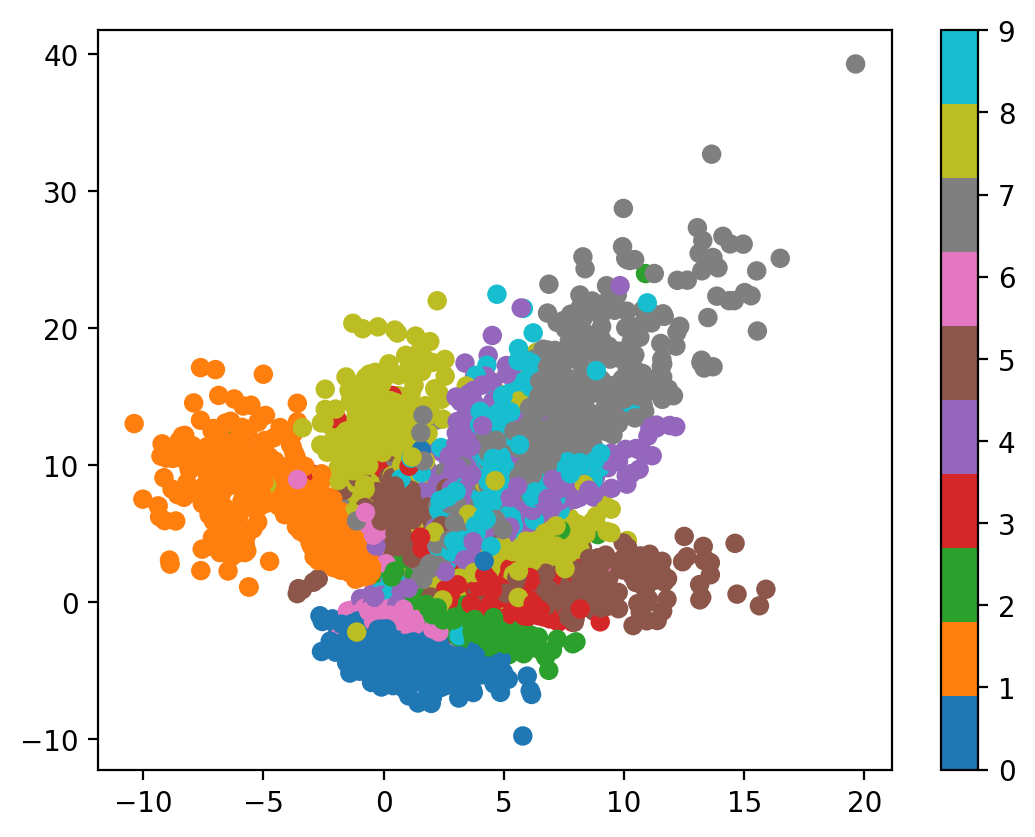

In [43]:
plot_latent(autoencoder, trainloaded)

In [47]:
def reconstructdigits(autoencoder, r0=(-5, 10), r1=(-10, 5), n=15):
    w=28
    image = np.zeros((n*w, n*w))
    for i, x2 in enumerate(np.linspace(*r1, n)):
        for j, x1 in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x1, x2]]).to(device)
            xhat = autoencoder.decoder(z)
            xhat = xhat.reshape(28, 28)
            xhat = xhat.to('cpu')
            xhat = xhat.detach().numpy()
            image[(n-i-1)*w:(n-i)*w, j*w:(j+1)*w] = xhat
    plt.imshow(image, extent=[*r0, *r1])

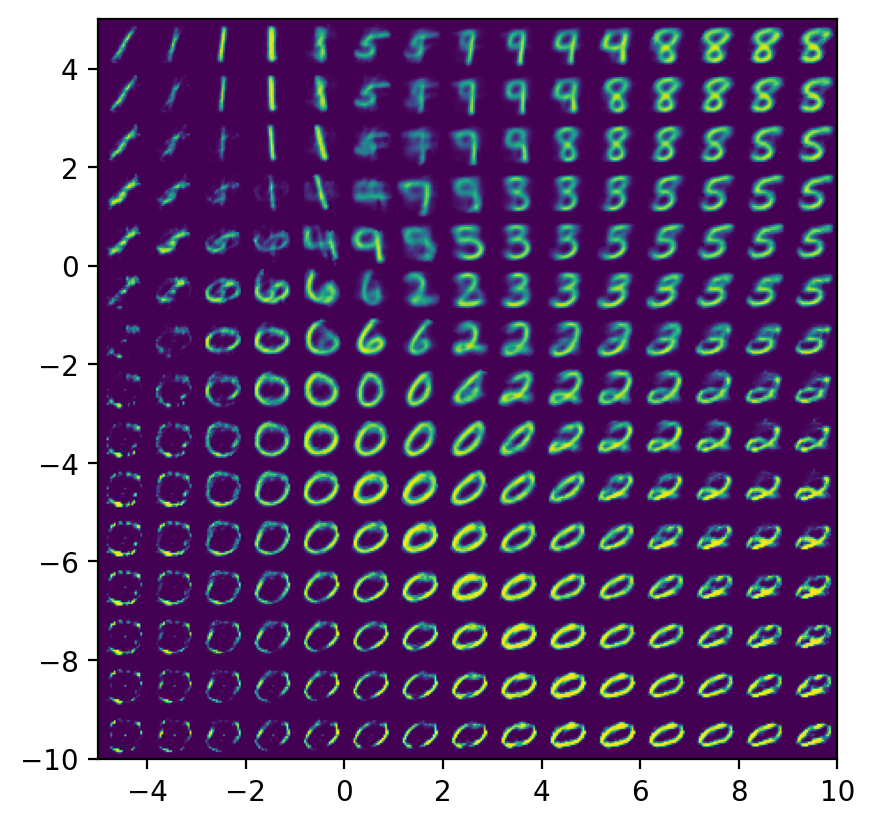

In [48]:
reconstructdigits(autoencoder)